In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras import backend as K
from tensorflow import keras

import numpy as np

In [3]:
import os

cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb" in x]
test_cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb01" in x or "chb02" in x or "chb03" in x]
# cases = ["chb01", "chb02"]
# generate_train_data(sequence_length=256, stride=256, cases=cases)

In [4]:
from seizure_sequence import SeizureSequence

seizure_sequence = SeizureSequence(1, "ml_processed_balanced", cases)
data, labels = seizure_sequence.__getitem__(1)
# for inddata in data:
#     if inddata.shape != (23, 256):
#         print(inddata.shape)

In [26]:
from model import ModelTools
m = ModelTools()
model = m.compile_model(m.create_model(dropout=True, dropout_rate=0.25))
model.summary()
histories = []

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 19, 512)           655872    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 9, 512)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 9, 512)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 7, 256)            393472    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 3, 256)           0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 3, 256)           

In [32]:
# tf_dataset = seizure_sequence.create_tf_dataset()
history = model.fit(seizure_sequence, epochs=500)
histories.append(history)

Epoch 1/500
191/191 [==============================] - 1s 8ms/step - loss: 0.1710 - accuracy: 0.9354
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1540 - accuracy: 0.9430
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1593 - accuracy: 0.9420
Epoch 4/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1575 - accuracy: 0.9410
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1659 - accuracy: 0.9386
Epoch 6/500
191/191 [==============================] - 2s 8ms/step - loss: 0.1582 - accuracy: 0.9409
Epoch 7/500
191/191 [==============================] - 2s 8ms/step - loss: 0.1738 - accuracy: 0.9344
Epoch 8/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1618 - accuracy: 0.9402
Epoch 9/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1556 - accuracy: 0.9431
Epoch 10/500
191/191 [==============================] - 1s 7ms/step - loss: 0.1779 - accura

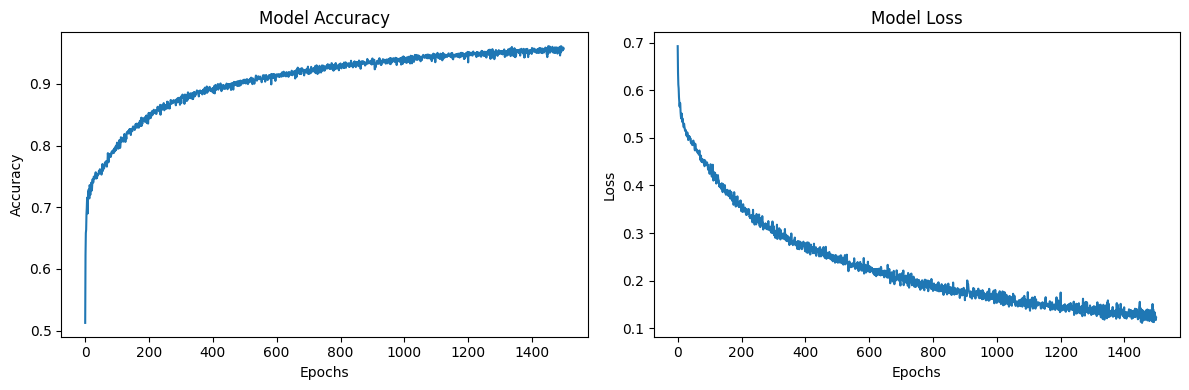

In [33]:
combined_history = {}
for history in histories:
    for key in history.history.keys():
        if combined_history.get(key) is not None:
            combined_history[key] = combined_history[key] + history.history[key]
        else:
            combined_history[key] = history.history[key]
m.accuracy_loss_plot(histories)

In [20]:
data = np.load("ml_processed/chb01_03.edf_data.npy")
labels = np.load("ml_processed/chb01_03.edf_labels.npy")
# for i in range(0, len(labels)):
#     if labels[i][0] == 1:
#         print(i)
# print(data.shape)
known_seizures = data[3000:3020]
# print(known_seizures.shape)
known_seizure_label = labels[3000:3020]
for label in known_seizure_label:
    if label == 0:
        print("OOPS")

seizure_guesses = []
for known_seizure in known_seizures:
    # print(known_seizure.shape)
    reshaped = np.reshape(known_seizure, (-1, 23, 256))
    guess = model.predict(reshaped)
    if guess[0][0][0] > 0.4:
        seizure_guesses.append((guess[0][0][0], 1))
    else:
        seizure_guesses.append((guess[0][0][0], 0))

known_normal = data[0:20]
# print(known_seizures.shape)
known_normal_label = labels[0:20]
for label in known_normal_label:
    if label == 1:
        print("OOPS")


normal_guesses = []
for known_normal in known_normal:
    # print(known_seizure.shape)
    reshaped = np.reshape(known_normal, (-1, 23, 256))
    guess = model.predict(reshaped)
    if guess > 0.4:
        normal_guesses.append((guess[0][0][0], 1))
    else:
        normal_guesses.append((guess[0][0][0], 0))

1/1 [==============================] - 0s 21ms/step


In [49]:
print(seizure_guesses)
print(normal_guesses)

[(1.0, 1), (0.9999938, 1), (1.0, 1), (0.9999989, 1), (0.999997, 1), (0.9999982, 1), (0.9999994, 1), (0.9998103, 1), (0.9992229, 1), (0.97487813, 1), (0.99999964, 1), (0.9992398, 1), (0.99752086, 1), (0.9967823, 1), (0.98222464, 1), (0.98723143, 1), (0.9999862, 1), (0.9983444, 1), (0.9901467, 1), (0.99967873, 1)]
[(0.25444618, 0), (0.45362905, 1), (0.051876046, 0), (0.0687711, 0), (0.27691266, 0), (0.435649, 1), (0.078774706, 0), (0.08586156, 0), (0.046561837, 0), (0.05535594, 0), (0.01639884, 0), (0.031711023, 0), (0.007934709, 0), (0.15840216, 0), (0.16857506, 0), (0.07052687, 0), (0.18661611, 0), (0.13083935, 0), (0.079469986, 0), (0.02712321, 0)]


had to drop chb12-27, the sensors changed and they are different from everything else.

In [86]:
# from data import generate_balanced_train_data
# import os
# cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb" in x]
# generate_balanced_train_data(256,256,cases)

In [34]:
file = seizure_sequence.get_test_file()
whole_file_data = np.load("ml_processed//" + file + "_data.npy")
whole_file_labels = np.load("ml_processed/" + file + "_labels.npy")

predictions = model.predict(whole_file_data)

threshold = 0.5
best_threshold = threshold
best_accuracy = 0
lowest_false_neg = float('inf')
detail = 10
for i in range(0, 501):
    false_pos = 0
    true_pos = 0
    false_neg = 0
    true_neg = 0
    for i, prediction in enumerate(predictions):
        p = prediction[0][0]
        # if p == 1:
        if p > threshold:
            if whole_file_labels[i] == 0:
                false_pos += 1
            else:
                true_pos += 1
        else:
            if whole_file_labels[i] == 1:
                false_neg += 1
            else:
                true_neg += 1
    whole_file_accuracy = ((true_pos + true_neg) / whole_file_data.shape[0]) * 100
    if false_neg <= lowest_false_neg and true_pos > 0 and whole_file_accuracy > best_accuracy:
        lowest_false_neg = false_neg
        best_accuracy = whole_file_accuracy
        best_threshold = threshold
    threshold = round(threshold + 0.001, 3)

# print(f"Best threshold: {best_threshold}\nBest accuracy: {best_accuracy} \nLowest false neg: {lowest_false_neg}")



false_pos = 0
true_pos = 0
false_neg = 0
true_neg = 0
for i, prediction in enumerate(predictions):
    p = prediction[0][0]
    # if p == 1:
    if p > best_threshold:
        if whole_file_labels[i] == 0:
            false_pos += 1
        else:
            true_pos += 1
    else:
        if whole_file_labels[i] == 1:
            false_neg += 1
        else:
            true_neg += 1
whole_file_accuracy = ((true_pos + true_neg) / whole_file_data.shape[0]) * 100
print("\t false", "\t", "true")
print("pos \t", false_pos, "\t", true_pos)
print("neg \t", false_neg, "\t", true_neg)
print(f"\nBest Threshold: {best_threshold}, Correct: {round(whole_file_accuracy, 2)}%")

113/113 [==============================] - 1s 4ms/step
	 false 	 true
pos 	 110 	 39
neg 	 0 	 3450

Best Threshold: 0.895, Correct: 96.94%


In [25]:
model.save("models/ictal_model_3500_epoch_new_arch.h5")